In [1]:
%load_ext autoreload
%autoreload 2


import dvu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import clean
import viz

plt.style.use('default')
dvu.set_style()

df = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')

def get_feature_names_list(schema):
    if isinstance(schema, list):
        return [clean.clean_feature_name(s['label_en']) if 'label_en' in s else 'unknown'
                for s in schema]
    else:
        return []

# these seem to be extra info in the calc, not actually a new feature
def remove_unknown(x):
    return [z for z in x if not z == 'unknown']

df['feature_names'] = df['input_schema'].apply(get_feature_names_list)
df['feature_names'] = df['feature_names'].apply(remove_unknown)

**Clean the feature names**

In [2]:
feature_names_unique = df['feature_names'].apply(clean.get_renamed_unique_feature_names_from_list)
all_words = sum(feature_names_unique, [])  # concatenate all list

all_words = pd.Series(all_words)
# all_words = all_words[~(all_words == 'unknown')] # not necessary, already handleed
counts = all_words.value_counts()
feat_names = pd.Series(counts.index)

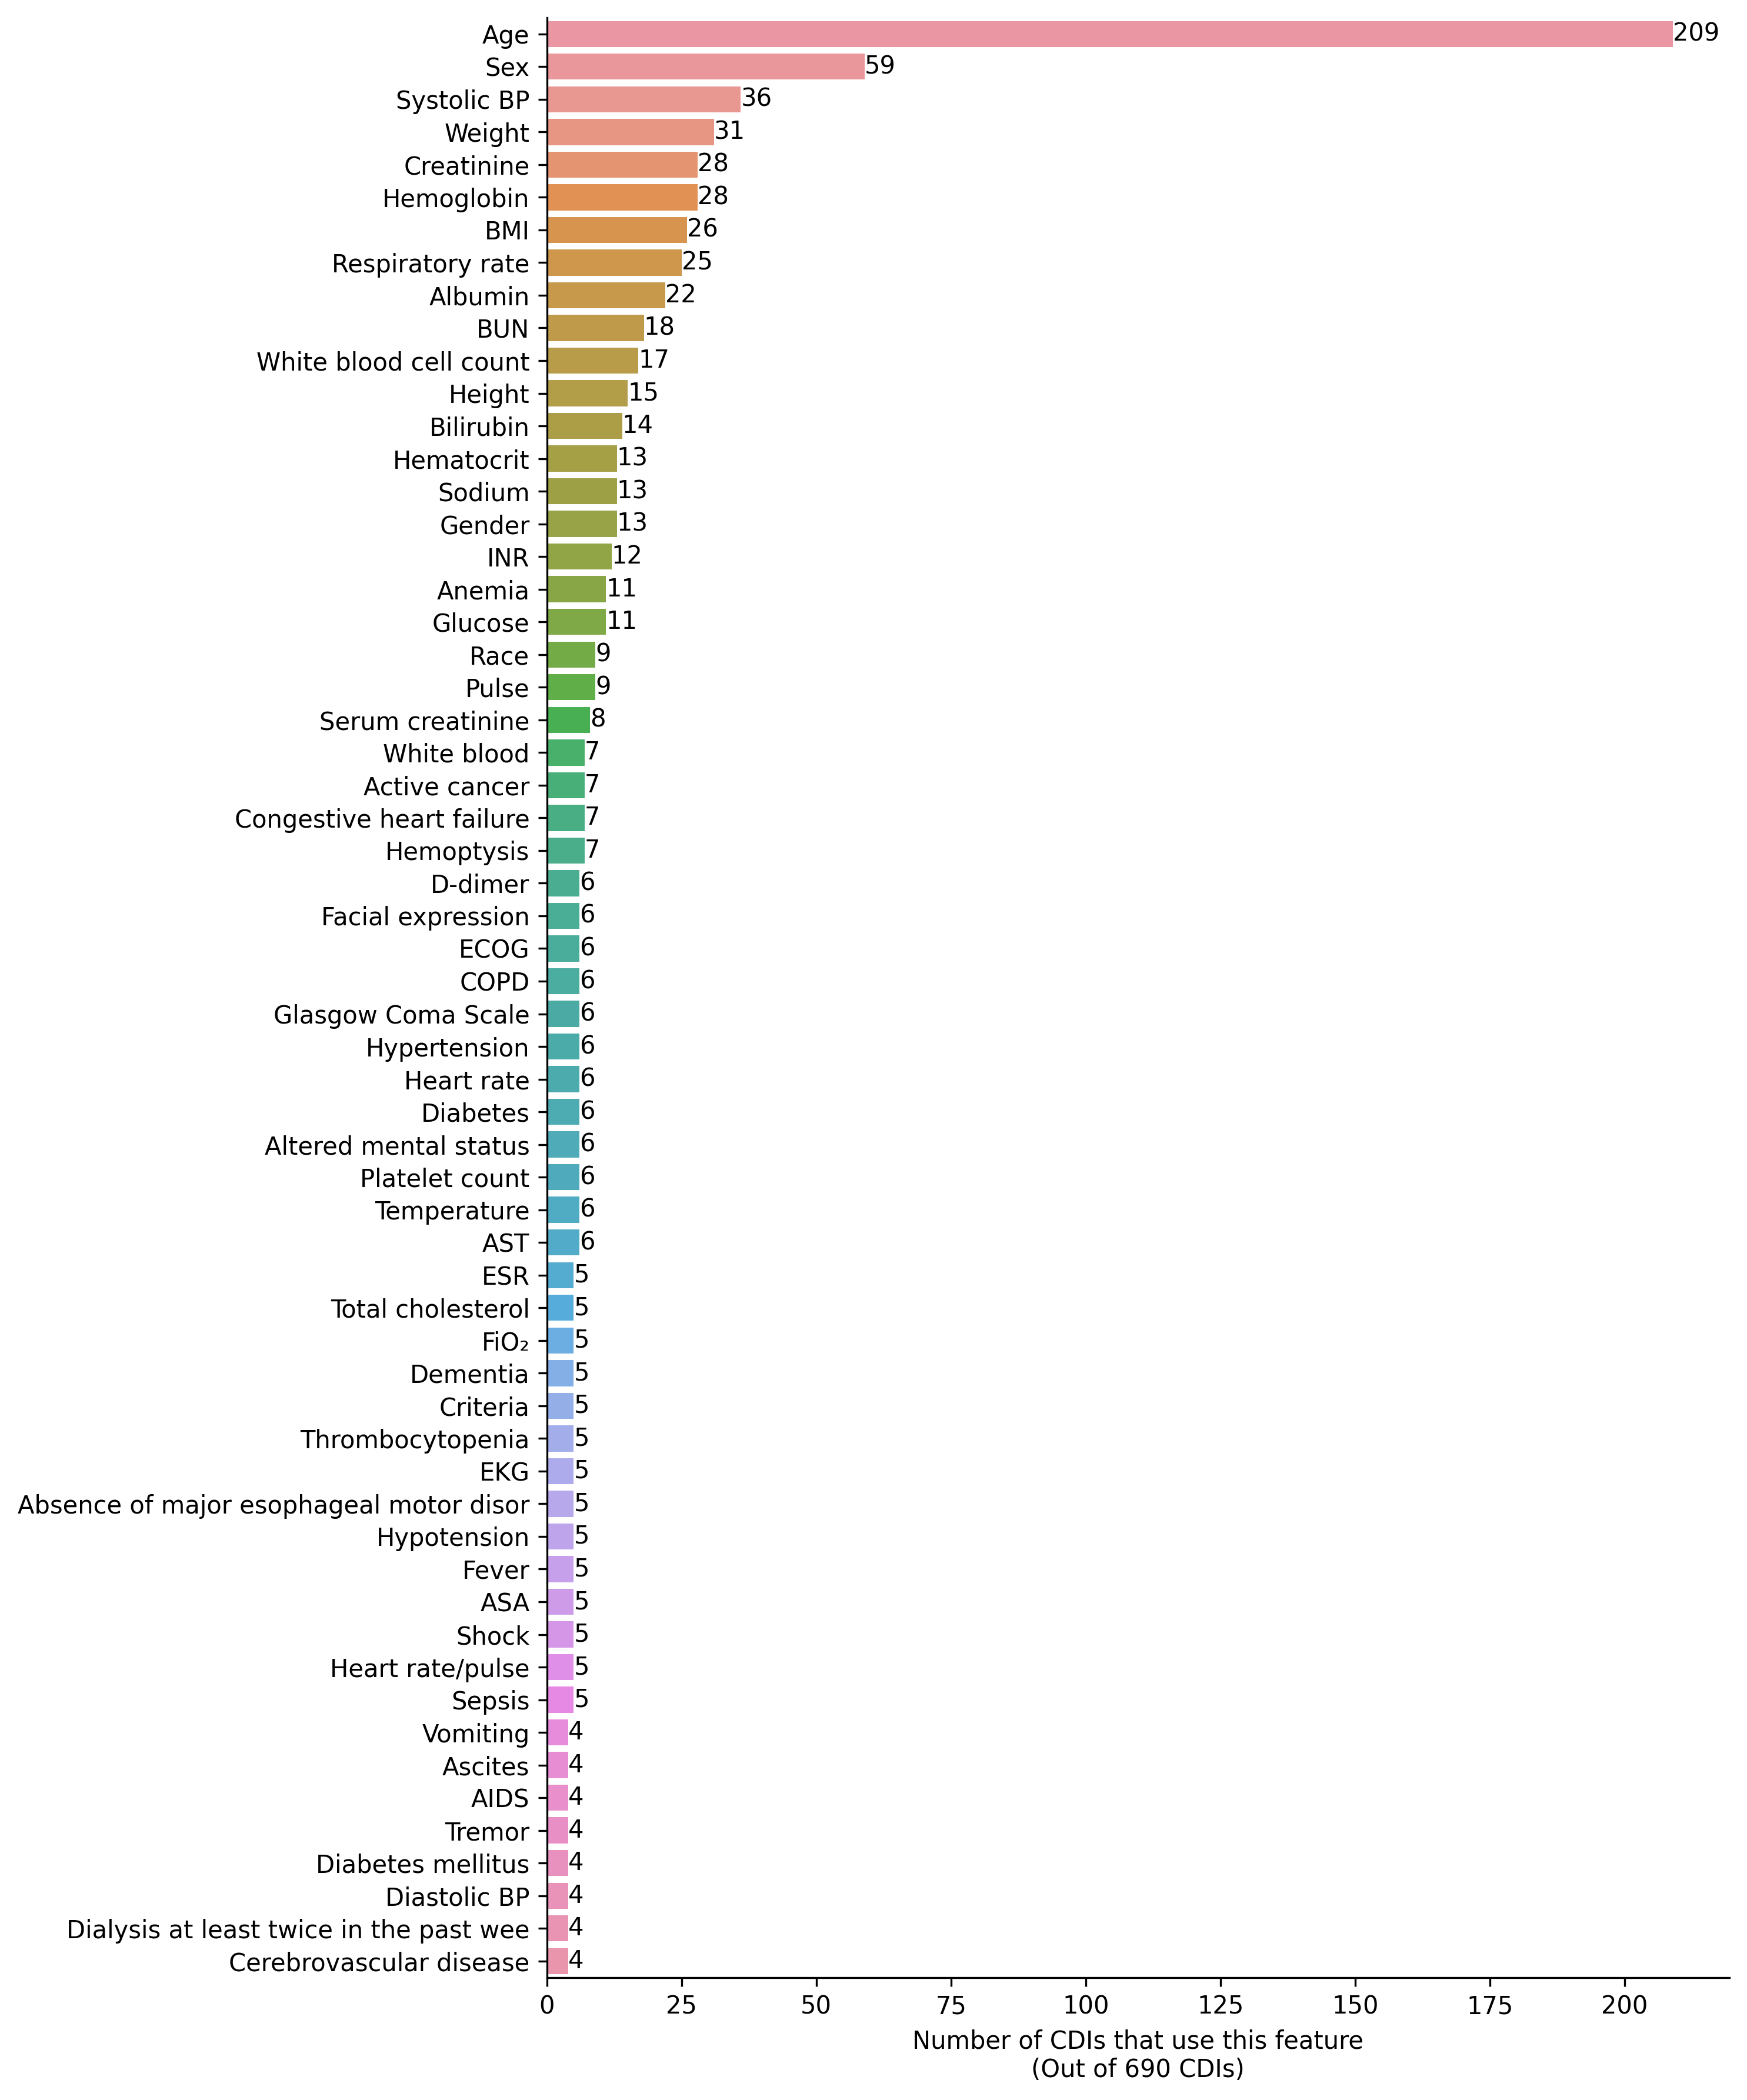

In [3]:
plt.figure(figsize=(10, 12), dpi=300, facecolor='w')
N = 60
# plt.grid()
ax = sns.barplot(y=feat_names[:N].apply(lambda x: x[:39]),
                 x=counts.values[:N], orient='h')
ax.bar_label(ax.containers[0])
plt.xlabel(f'Number of CDIs that use this feature\n(Out of {df.shape[0]} CDIs)')
plt.tight_layout()
viz.savefig('common_features')

**Look at the renaming**

In [4]:
feats_print = sorted(set(sum(df['feature_names'], [])))
df_print = pd.DataFrame(feats_print, columns=['Original feature'])
df_print['Chandan rename'] = df_print['Original feature'].apply(clean.rename_feature_name)
idxs_same = df_print['Chandan rename'] == df_print['Original feature']
df_print['Chandan rename'][idxs_same] = ''
df_print.to_csv('../data/renaming/features.csv', index=False)

# feature counts

In [7]:
df['num_splits'] = df['feature_names'].apply(len)
df['num_features_unique'] = df['feature_names']\
    .apply(clean.get_renamed_unique_feature_names_from_list)\
    .apply(len)

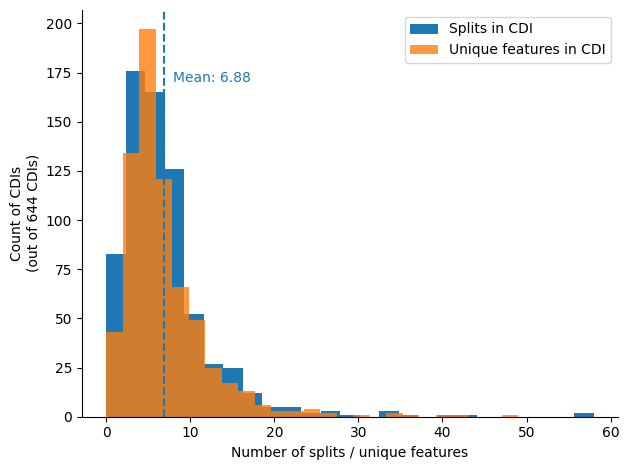

In [8]:
# plt.figure(dpi=300, facecolor='w')
plt.hist(df['num_splits'], label='Splits in CDI', bins=25)
avg = np.mean(df['num_splits'])
plt.axvline(x=avg, ls='--')
plt.text(s=f'Mean: {avg:0.2f}', x=avg + 1, y=170, color='C0')
plt.hist(df['num_features_unique'], label='Unique features in CDI', bins=25, alpha=0.8)
plt.xlabel('Number of splits / unique features')
plt.ylabel('Count of CDIs\n(out of 644 CDIs)')
plt.legend()
viz.savefig('num_rules_hist')
# plt.show()

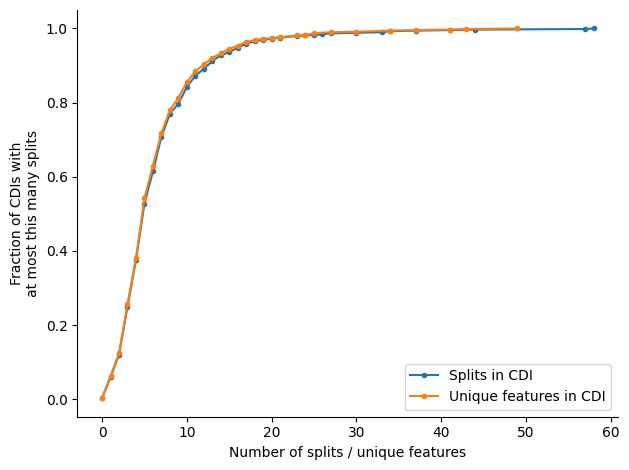

In [9]:
vals, counts = np.unique(df['num_splits'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Splits in CDI')
# val_90 = (np.cumsum(counts) / np.sum(counts)) >= 0.9

# plt.show()
vals, counts = np.unique(df['num_features_unique'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Unique features in CDI')

plt.xlabel('Number of splits / unique features')
plt.ylabel('Fraction of CDIs with\nat most this many splits')
plt.legend()
viz.savefig('num_rules_cdf')
plt.show()